In [1]:
# Library imports
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import tools
from train import generate_graph, train

# Reproducibility

The results of this notebook are not deterministic. Therefore, the results from a previous run are loaded here. Run this cell instead of the cells in the following section ('Experiment Code') in order to generate an identical plot to the accompanying paper in the 'Plot' section at the end of the notebook.

In [2]:
# Load the previous results
with open('saved_results//hyperparameters_edges_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Experiment Code

In [3]:
# Fix random seed for reproducibility
np.random.seed(628496)

# Stop on errors
np.seterr('raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
results = {}

base_rates_by_acc = np.array([0.25, 0.1])

for activity_multiplier in tqdm(np.arange(0.1, 2.1, 0.1)):
    # Generate the synthetic data with different activity rates
    edges_by_day, last_day, raw_accounts = \
        tools.simulate_many_nodes(
            average_rates_by_acc=tuple(base_rates_by_acc * activity_multiplier)
        )

    # Count the number of generated edges
    count_edges = sum(len(day) for day in edges_by_day.values())

    # Start recording the time
    start_time = time.time()

    # Create a graph object
    graph = generate_graph(
        raw_accounts=raw_accounts,
        edges_by_day=edges_by_day,
        last_day=last_day,
        node_dimension=32,
        graph_kwords={
            'causal_learning_rate': 0.01,
            'weight_regularisation_rate': 10**(-5),
            'spontaneous_regularisation_rate': 10**(-7)
        }
    )

    # Train
    probabilities = train(
        graph, edges_by_day, last_day, iterations=50,
        plot_log_likelihood=False, use_tqdm=False,
        spontaneous_learning_startpoint=25
        )

    # Stop the timer
    end_time = time.time()

    # Print and record the results
    print(f'{count_edges} edges, '
          f'time taken: {(end_time-start_time)/60:,.4f} minutes, '
          f'final log-likelihood: {probabilities[-1]:,.2f}')
    results[count_edges] = {
        'time_taken': (end_time-start_time)/60,
        'log_likelihood': probabilities[-1]
    }

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


24 edges, time taken: 0.2815 minutes, final log-likelihood: -788.90


  8%|▊         | 4/50 [00:02<00:31,  1.46it/s]


KeyboardInterrupt: 

In [ ]:
# Save the results
with open('saved_results//hyperparameters_edges_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Plot

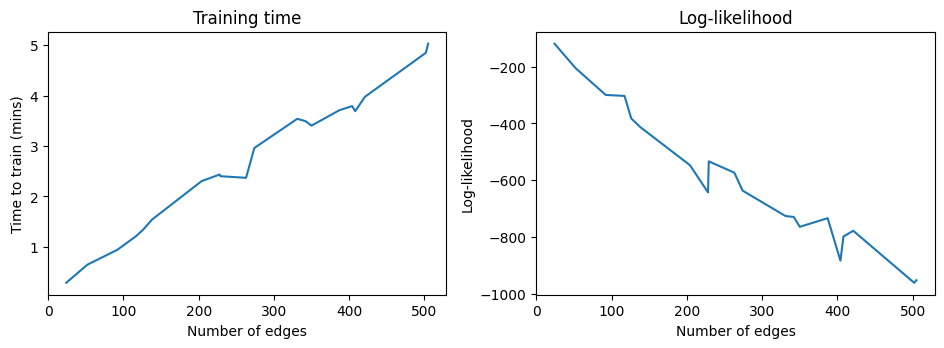

In [ ]:
# Create the x-axis data
edge_numbers = np.array(list(edge_count for edge_count in results.keys()))
edge_numbers.sort()

# Create the subplots
fig, axes = plt.subplots(1, 2)

fig.tight_layout()
fig.set_figwidth(10)
fig.set_figheight(3)

# Create the y-axis data for the time taken
times = np.array([results[edge_count]['time_taken'] for edge_count in edge_numbers])

# Plot the time taken
axes[0].plot(
    edge_numbers, times
)
axes[0].set_xlabel('Number of edges')
axes[0].set_ylabel('Time to train (mins)')
axes[0].set_title('Training time')

# Create the y-axis data for the log-likelihood
log_likelihoods = np.array([results[edge_count]['log_likelihood'] for edge_count in edge_numbers])

# Plot the log-likelihood
axes[1].plot(
    edge_numbers, log_likelihoods
)

axes[1].set_xlabel('Number of edges')
axes[1].set_ylabel('Log-likelihood')
axes[1].set_title('Log-likelihood')

plt.show()